<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 10: Modellierung
## Create gravity and magnetic model
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, calculate Bouguer and total-field anomalies for a group of spherical bodies.
<img src="images/3Dboug_total.png" style="height:10cm">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import lib_modelling
#lib_modelling.change_fontsize()

----
## Create topography

Create topographical data on regular grid, save to file
$$
topo(x,y) = \left\{
\begin{array}{ll}
T_o, & \mbox{flat} \\
T_o+T_a\cos(\frac{\pi x}{50}), & \mbox{cosine} \\
T_o+T_a\sin(\frac{\pi x}{100}), & \mbox{sine} \\
T_o+T_a\sqrt{-\frac{(x-\mu)^2+(y-\mu)^2}{\sigma^2}}, & \mbox{gauss}
\end{array}
\right.
$$

In [2]:
def GP_topo(nx=51,ny=51,To=200,Ta=5,topo_type='flat',mu=0.,sigma=30.):
    xmin=-50;xmax=50
    ymin=-50;ymax=50
    x,dx = np.linspace(xmin,xmax,nx,retstep=True)
    y,dy = np.linspace(ymin,ymax,ny,retstep=True)
    # re-mesh for 2D plot
    X, Y = np.meshgrid(y,x)
    if (topo_type == 'flat'):
        TOPO = To + 0*X
    elif (topo_type == 'cosine'):
        TOPO = To + Ta + Ta*np.cos(np.pi*X/50) + 0*X
    elif (topo_type == 'sine'):
        TOPO = To + Ta + Ta*np.sin(np.pi*X/100) + 0*X
    elif (topo_type == 'gauss'):
        TOPO = To + Ta * np.exp(-((X-mu)**2+(Y-mu)**2)/sigma**2) + 0*X
    else:
        print('No topo typ defined')
    ZTOP = 1000.
    Z = ZTOP - TOPO
    return X,Y,TOPO,Z,ZTOP

In [3]:
def GP_signal(X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG):
    """
    function calculates forward model for gravity and magnetics
    based on input coordinates
    and forward operators (spheres) from lecture
    X,Y,Z    - DEM model (easting,northing,elevation wrt plane ZTOP)
    XP,YP,ZP - center coordinate of model boxes
    RP       - radius of model boxes
    RHOP,MAG - density and magnetisation of model boxes
    returns
    boug     - Bouguer gravity signal from model boxes
    total    - Total field signal from model boxes
    """
    boug  = np.zeros_like(X)
    total = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for k in range(len(XP)):
                gx,gy,gz = lib_modelling.grav_sphere(xo=X[i,j],yo=Y[i,j],zo=Z[i,j],
                                       xp=XP[k],yp=YP[k],zp=ZTOP-ZP[k],radius=RP[k],rho=RHOP[k])
                boug[i,j] = boug[i,j] + gz
                bx,by,bz,t = lib_modelling.mag_sphere(xo=X[i,j],yo=Y[i,j],zo=Z[i,j],
                                        xp=XP[k],yp=YP[k],zp=ZTOP-ZP[k],radius=RP[k],
                                earthincl=67.,earthdecl=0.,mag=MAG[k],incl=90.,decl=0.,theta=0.)
                total[i,j] = total[i,j] + t
    return boug,total

In [4]:
def GP_plot(X,Y,BOUG,TOTAL):
    fig,axs = plt.subplots(1,2,figsize=(10,6))

    axs[0].set_title('Cavity')

    levels = np.array([i for i in np.linspace(-0.6,0,11)])
    axs[0].axis('equal')
    axs[0].set_xlabel('Easting [m]')
    axs[0].set_ylabel('Northing [m]')
    CS1=axs[0].contourf(X, Y, BOUG,cmap=plt.cm.jet_r,levels=levels)
    CS2= axs[0].contour(X, Y, BOUG,colors='white',levels=levels)
    axs[0].clabel(CS2, inline=1, fontsize=10,fmt='%5.1f',colors='black')
    cbar = fig.colorbar(CS1,ax=axs[0],orientation="horizontal",shrink=0.9)
    cbar.ax.set_xlabel('Gravity [mGal]')

    levels = np.array([i for i in np.linspace(-100,100,21)])
    axs[1].axis('equal')
    axs[1].set_xlabel('Easting [m]')
    #axs[1].set_ylabel('Northing [m]')
    CS3=axs[1].contourf(X, Y, TOTAL,cmap=plt.cm.jet,levels=levels)
    CS4= axs[1].contour(X, Y, TOTAL,colors='white',levels=levels)
    axs[1].clabel(CS4, inline=1, fontsize=10,fmt='%5.1f',colors='black')
    cbar = fig.colorbar(CS3,ax=axs[1],orientation="horizontal",shrink=0.9)
    cbar.ax.set_xlabel('Total field [nT]')

----
## Compare different scenarios

### One sphere, flat topography

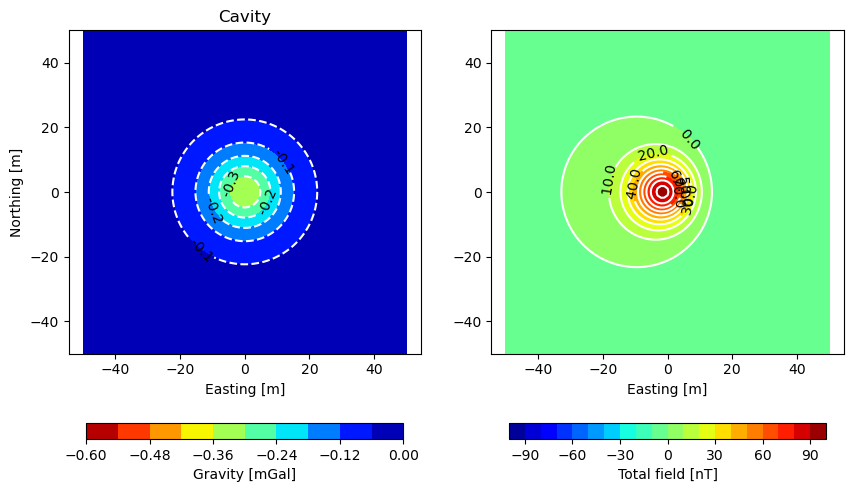

In [5]:
nx=101;ny=101

XP=[0.]
YP=[0.]
ZP=[185.]
RP =[10.]
RHOP =[-2800]
MAG = [0.4]

X,Y,TOPO,Z,ZTOP = GP_topo(nx=nx,ny=ny,To=200.,Ta=5.,topo_type='flat')
BOUG,TOTAL = GP_signal(X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)
GP_plot(X,Y,BOUG,TOTAL)

### Two spheres, flat topography

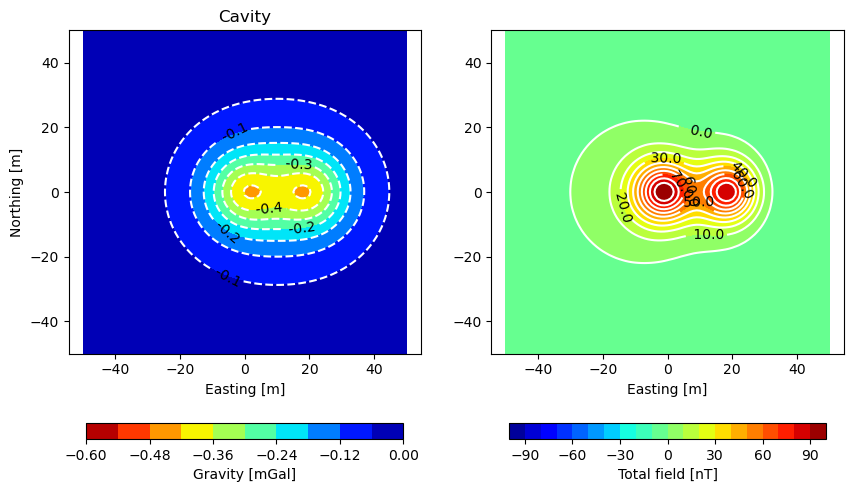

In [6]:
nx=101;ny=101

XP=[0.,20.]
YP=[0.,0.]
ZP=[185.,185.]
RP =[10.,10.]
RHOP =[-2800,-2800]
MAG = [0.4,0.4]

X,Y,TOPO,Z,ZTOP = GP_topo(nx=nx,ny=ny,To=200.,Ta=5.,topo_type='flat')
BOUG,TOTAL = GP_signal(X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)
GP_plot(X,Y,BOUG,TOTAL)

### Three spheres, flat topography

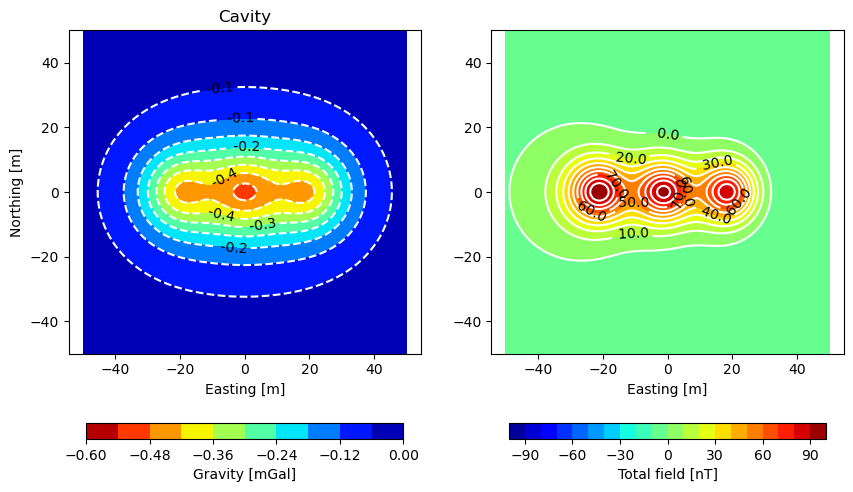

In [7]:
nx=101;ny=101

XP=[-20.,0.,20.]
YP=[0.,0.,0.]
ZP=[185.,185.,185.]
RP =[10.,10.,10.]
RHOP =[-2800,-2800,-2800]
MAG = [0.4,0.4,0.4]

X,Y,TOPO,Z,ZTOP = GP_topo(nx=nx,ny=ny,To=200.,Ta=5.,topo_type='flat')
BOUG,TOTAL = GP_signal(X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)
GP_plot(X,Y,BOUG,TOTAL)

### Three spheres, gauss topography

<IPython.core.display.Javascript object>


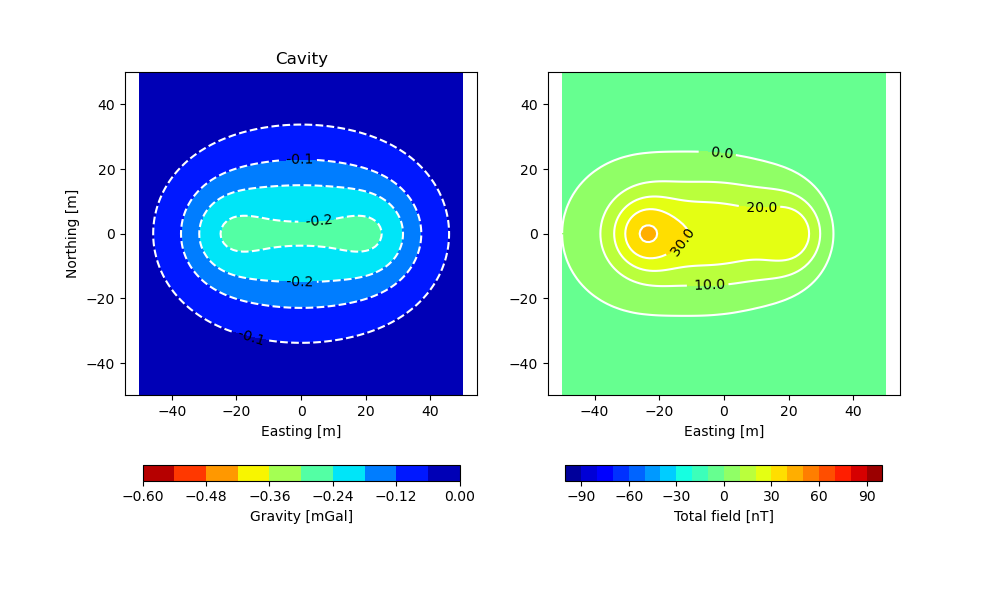

In [13]:
nx=101;ny=101

XP=[-20.,0.,20.]
YP=[0.,0.,0.]
ZP=[185.,185.,185.]
RP =[10.,10.,10.]
RHOP =[-2800,-2800,-2800]
MAG = [0.4,0.4,0.4]

X,Y,TOPO,Z,ZTOP = GP_topo(nx=nx,ny=ny,To=200.,Ta=10.,topo_type='gauss')
BOUG,TOTAL = GP_signal(X,Y,Z,XP,YP,ZP,ZTOP,RP,RHOP,MAG)
GP_plot(X,Y,BOUG,TOTAL)

----
## Plot 3D map

<IPython.core.display.Javascript object>


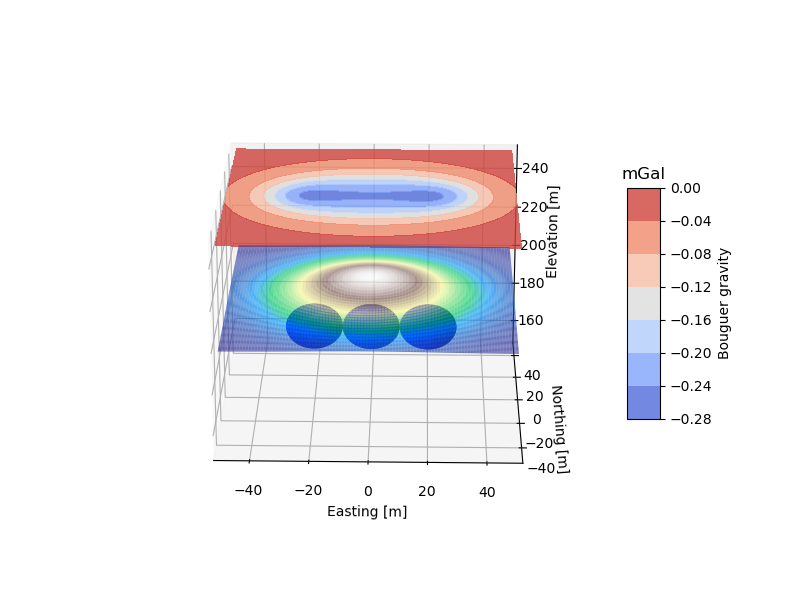

In [14]:
%matplotlib notebook

axs = plt.figure(figsize=(8.0,6.0)).add_subplot(projection='3d')
# 3D axes
axs.set_xlim(X.min(),X.max())
axs.set_ylim(Y.min(),Y.max())
axs.set_zlim(150,250)
axs.set_xlabel('Easting [m]')
axs.set_ylabel('Northing [m]')
axs.set_zlabel('Elevation [m]')

# topography as 2D plot
surf=axs.contourf(X,Y,BOUG,zdir='z',offset=250,alpha=0.8,cmap = plt.get_cmap('coolwarm'))

# topography as 3D surface
axs.plot_surface(X,Y,TOPO,rstride=1, cstride=1, alpha=0.7, linewidth=0,cmap=plt.get_cmap('terrain'))

# sphere as 3D object
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
for i in range(len(XP)):
    xsphere = XP[i] + RP[i] * np.outer(np.cos(u), np.sin(v))
    ysphere = YP[i] + RP[i] * np.outer(np.sin(u), np.sin(v))
    zsphere = ZP[i] + RP[i] * np.outer(np.ones(np.size(u)), np.cos(v))
    axs.plot_surface(xsphere, ysphere, zsphere,  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.9)

# colorbar
cbar=plt.colorbar(surf, shrink=0.5, aspect=7)
cbar.ax.set_title('mGal')
cbar.set_label('Bouguer gravity')

... done